# Notebook 2 - Isotropic Model

- This notebook demonstrates the bayesian statistical analysis preformed Antikythera Calender the using the Isotropic model $(\sigma = \sigma_r = \sigma_t)$
- Notebook 1 acts as the main tutorial page, explaining the packages functionalities and justifyng the packages stucture

In [ ]:
# Import necessary libraries
import jax.numpy as jnp
import pandas as pd
from calender_analysis import Calender_Analysis 
# ------------------ Data ------------------
original_data_path = "data/Hole_Measurements.csv"  
# ------------------ Rerun Computationally Expensive Analysis ------------------
rerun_comp_expensive_analysis = False

## Initialising the Models
The data analysis is preformed within a class based structure called **Calender_Analysis**

Details on the **filtering options** and implementation of the **model** can be found in `Notebook 1`

### Filtering Choice

Once again we use the default filtering initialisation where sections with 1 hole are removed as they do not help constrain any of the universal parameters (same as Notebook 1)


### Default Priors

Reiterated for clarity

| **Parameter**       | **Description**                        | **Distribution**         |
|---------------------|----------------------------------------|--------------------------|
| **$N$**              | Total number of holes                  | Uniform(340, 370)       |
| **$r$**              | Ring radius                            | Uniform(65, 85)         |
| **$x_0$**         | Section offsets (x dim)                      | Normal(80, 5) |
| **$y_0$**         | Section offsets  (y dim)                    | Normal(135, 5) |
| **$\alpha$**              | Angular offsets                       | Normal(-2.5, 1)         |
| **$Errors$**    | **Isotropic**                          | **σ** ~ Uniform(0, 5)   |

In [2]:
Antikythera_Isotropic_Basic_Filter = Calender_Analysis(data = original_data_path, model_type = "isotropic", filtering = 'Basic', priors = None, num_cores = 4)

2025-03-11 18:29:34,896 - INFO - JAX Detected Devices: 8
2025-03-11 18:29:34,897 - INFO - JAX configured to use 4 devices for parallel chains.
2025-03-11 18:29:34,906 - INFO -  
        DATA SUMMARY
Total Sections   : 6
Total Holes      : 79
---------------------------------
Section ID   |   Hole Range 
--------------------------------- 
      1      |   2 - 23
      2      |   24 - 32
      3      |   33 - 69
      4      |   71 - 73
      5      |   74 - 75
      6      |   76 - 81 
--------------------------------- 


INFO:2025-03-11 18:29:34,918:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-03-11 18:29:34,918 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-03-11 18:29:34,920:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


2025-03-11 18:29:34,920 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


### Plotting Observed Data
- Details and plots can be found in Notebook 1

## Likelihood Function

The log-likelihood is given by:

### **Isotropic Model**
$$
\log L = -\frac{1}{2} \sum_i \left(\frac{(e_{i,x})^2 + (e_{i,y})^2}{\sigma^2} \right) - n \log(2\pi\sigma^2)
$$
where:
- $ e_{i,x} = x_{\text{obs},i} - x_{\text{model},i} $ (x-coordinate error)
- $ e_{i,y} = y_{\text{obs},i} - y_{\text{model},i} $ (y-coordinate error)
- $ \sigma $ represents a shared uncertainty in both directions.

## Implementation

The code contains the following two functions: 

### **`.hole_positions`**
This function computes the expected x and y positions of holes based on the model parameters. It assumes the holes are arranged in a circular ring and accounts for section-specific displacements and rotations.

**Inputs:**
- **N**: Total number of holes in the original unfragmented ring.
- **r**: Estimated radius of the ring.
- **x0, y0**: Section-specific x and y offsets.
- **alpha**: Angular offsets for each section.
- **section_ids**: (Optional) Identifiers for each section, defaults to observed data.
- **hole_nos**: (Optional) Hole numbers corresponding to each modeled hole, defaults to observed data.

**Outputs:**
- A 2D array of shape (N_holes, 2), containing the expected x and y coordinates of each hole.

### **`.likelihood`**
This function evaluates how well the observed hole positions match the expected positions under a **Gaussian error model**. It supports both **isotropic** (single error term) and **anisotropic** (separate radial and tangential errors) models.

**Inputs:**
- **N, r, x0, y0, alpha**: Model parameters.
- **sigma**: Measurement uncertainty (single value for isotropic, two values for anisotropic).
- **log**: If True, returns the log-likelihood.
- **neg**: If True, returns the negative log-likelihood (useful for optimisation).
- **data**: (Optional) A subset of the dataset for mini-batch likelihood evaluation to support Supports **stochastic gradient descent (SGD)**

**Outputs:**
- Likelihood or log-likelihood value.




In [3]:
# Verifying functionality - this is done using the results from Woan & Bayley, 2024
# The sigma is reduced to a single value (arbitarily 0.1)
# Given values 
N = 355.24
r = 77.34
x0 = jnp.array([79.69, 79.91, 79.86, 81.44, 81.56, 83.22])
y0 = jnp.array([136.03, 135.71, 135.71, 136.10, 135.85, 136.42])
alpha_deg = jnp.array([-145.72, -145.67, -145.54, -146.71, -146.36, -147.80])
alpha = (jnp.radians(alpha_deg) + jnp.pi) % (2 * jnp.pi) - jnp.pi # Convert alpha from degrees to radians 
sigma = 0.1

# By not providing specific hole numbers and locations it will use those of the observed measurements
hole_positions = Antikythera_Isotropic_Basic_Filter.hole_positions(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha)
# Extract the hole numbers and sections used
hole_nos, section_nos = Antikythera_Isotropic_Basic_Filter.hole_nos_obs, Antikythera_Isotropic_Basic_Filter.section_ids_obs


# By not providing data to the likelihood function it will use that from the observed measurements
# Taking the value of the
likelihood_of_params = Antikythera_Isotropic_Basic_Filter.likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = False, neg = False, data = None)
log_likelihood_of_params = Antikythera_Isotropic_Basic_Filter.likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = True, neg = False, data = None)
neg_log_likelihood_of_params = Antikythera_Isotropic_Basic_Filter.likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = True, neg = True, data = None)

In [4]:
### Display results ###
hole_data = {
    "Hole ID": list(map(str, hole_nos)),
    "Section ID": list(map(str, section_nos)),
    "X Position": [f"{pos[0]:.2f}" for pos in hole_positions.tolist()],
    "Y Position": [f"{pos[1]:.2f}" for pos in hole_positions.tolist()]
}
hole_df = pd.DataFrame(hole_data)
print("\n### Hole Positions, Hole Numbers, and Section Numbers ###\n")
print(hole_df.to_string(index=False))

# Display the results for the likelihood function
print("\nLikelihood Values:")
print(f"Log-Likelihood: {log_likelihood_of_params:.6f}")
print(f"Negative Log-Likelihood: {neg_log_likelihood_of_params:.6f}")


### Hole Positions, Hole Numbers, and Section Numbers ###

Hole ID Section ID X Position Y Position
      2          1      16.56      91.35
      3          1      17.36      90.24
      4          1      18.18      89.14
      5          1      19.02      88.06
      6          1      19.88      87.00
      7          1      20.76      85.95
      8          1      21.65      84.91
      9          1      22.57      83.89
     10          1      23.50      82.89
     11          1      24.45      81.90
     12          1      25.41      80.94
     13          1      26.39      79.98
     14          1      27.39      79.05
     15          1      28.41      78.13
     16          1      29.44      77.24
     17          1      30.49      76.36
     18          1      31.55      75.50
     19          1      32.63      74.65
     20          1      33.72      73.83
     21          1      34.83      73.03
     22          1      35.95      72.25
     23          1      37.09      71.


#### **Almost Identical to that of Notebook 1, rerun for completeness and to ensure deriavtes are implemented correctly for Isotropic Model**

## Likelihood of Gradients

This pipeline has implemented two methods to generate the gradients of the derivative function:
Both take:
- **Inputs:** Model parameters (**N, r, x0, y0, alpha, sigma**), log-likelihood flag, and optional dataset (for stochastic gradient descent).
- **Output:** A dictionary of analytically computed gradients.

### **Automatic Differentiation**
This method leverages **JAX's jax.grad** to compute gradients numerically. It differentiates the likelihood function with respect to all model parameters without requiring explicit derivative calculations.

- **Function:** `.grad_likelihood()`

### **Analytical Differentiation**
This method explicitly derives the **partial derivatives** of the log-likelihood function using the **chain rule**. 

- **Function:** `.analytic_grad_loglikelihood()`


### **Comparison of Methods**

The function **compare_performance_grad()** systematically compares these methods by:
- Drawing **num_runs** random batch of data points to use in the gradient calculations
- For each run its measures:
    1. **Execution Time**: The speed of computing gradients.
    2. **Memory Usage**: The peak memory consumed by each approach.
	4. **Gradient Agreement**: Whether both methods produce gradients that match within a set **tolerance** (1e-3).

In [5]:
# Proof of derivates calculated on all data for both methods - with data = None uses full batch of observed data - preformed for log-likelihood
# Automatic differentiation
auto_diff = Antikythera_Isotropic_Basic_Filter.grad_likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = True, neg = False, data = None)
# Analytic differentiation
analytic_diff = Antikythera_Isotropic_Basic_Filter.analytic_grad_loglikelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, neg = False, data = None)

In [6]:
### Display results ###
def flatten_with_labels(param_name, values):
    if isinstance(values, (jnp.ndarray, list)) and values.ndim > 0: 
        return [(f"{param_name}_{i+1}", val) for i, val in enumerate(values.tolist())]
    return [(param_name, float(values))] 

flattened_data = []
for param in ["N", "r", "x0", "y0", "alpha", "sigma"]:
    flattened_data.extend(flatten_with_labels(param, auto_diff[param]))

comparison_rows = []
for label, auto_value in flattened_data:
    base_param = label.split("_")[0] 
    
    if "_" in label:
        index = int(label.split("_")[-1]) - 1 
        analytic_value = float(analytic_diff[base_param][index])  
    else:
        analytic_value = float(analytic_diff[base_param])
    
    diff_value = abs(auto_value - analytic_value)
    comparison_rows.append([label, auto_value, analytic_value, diff_value])

comparison_df = pd.DataFrame(comparison_rows, columns=["Parameter", "Auto-Diff", "Analytic-Diff", "Difference"])
print("\nGradient Comparison: Automatic vs Analytical Differentiation \n")
print(comparison_df.to_string(index=False))


Gradient Comparison: Automatic vs Analytical Differentiation 

Parameter   Auto-Diff  Analytic-Diff   Difference
        N    0.521325       0.521325 3.552714e-15
        r  -19.858355     -19.858355 3.552714e-15
     x0_1   21.502582      21.502582 3.552714e-15
     x0_2   -4.265598      -4.265598 5.329071e-15
     x0_3    3.736381       3.736381 1.065814e-14
     x0_4    0.900676       0.900676 0.000000e+00
     x0_5    0.226524       0.226524 0.000000e+00
     x0_6   -3.121075      -3.121075 1.776357e-15
     y0_1   32.949354      32.949354 0.000000e+00
     y0_2    7.846753       7.846753 1.776357e-15
     y0_3  -28.131028     -28.131028 0.000000e+00
     y0_4    1.983550       1.983550 2.220446e-16
     y0_5    1.930425       1.930425 0.000000e+00
     y0_6   -0.754319      -0.754319 0.000000e+00
  alpha_1 -523.947561    -523.947561 4.547474e-13
  alpha_2 -577.396201    -577.396201 2.273737e-13
  alpha_3  399.107470     399.107470 9.094947e-13
  alpha_4  107.213561     107.213561

In [7]:
# Run comparison over 100 samples with tolerance 1e-5, each run using 40 random data points from obersvations to calculate likelihood
comparison_results = Antikythera_Isotropic_Basic_Filter.compare_performance_grad(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, tolerance = 1e-5, num_runs = 100, subset_size = 40, return_results = True)

2025-03-11 18:29:47,577 - INFO - 
Performance & Accuracy Comparison (100 runs):
------------------------------------------------------------
Method:                 Auto-Diff              Manual-Diff
Avg Execution Time (s): 0.057691 ± 0.118809   0.021420 ± 0.116848
Avg Peak Memory (KB):   161.29 ± 77.55        58.12 ± 68.58
Gradient Agreement:      MATCH
Max Deviation:          2.728e-12
------------------------------------------------------------


## Maximum Likelihood Estimate

**Identical to implementation described in Notebook 1**


Optimizing MLE using Adam::   0%|          | 0/1 [00:00<?, ?it/s]

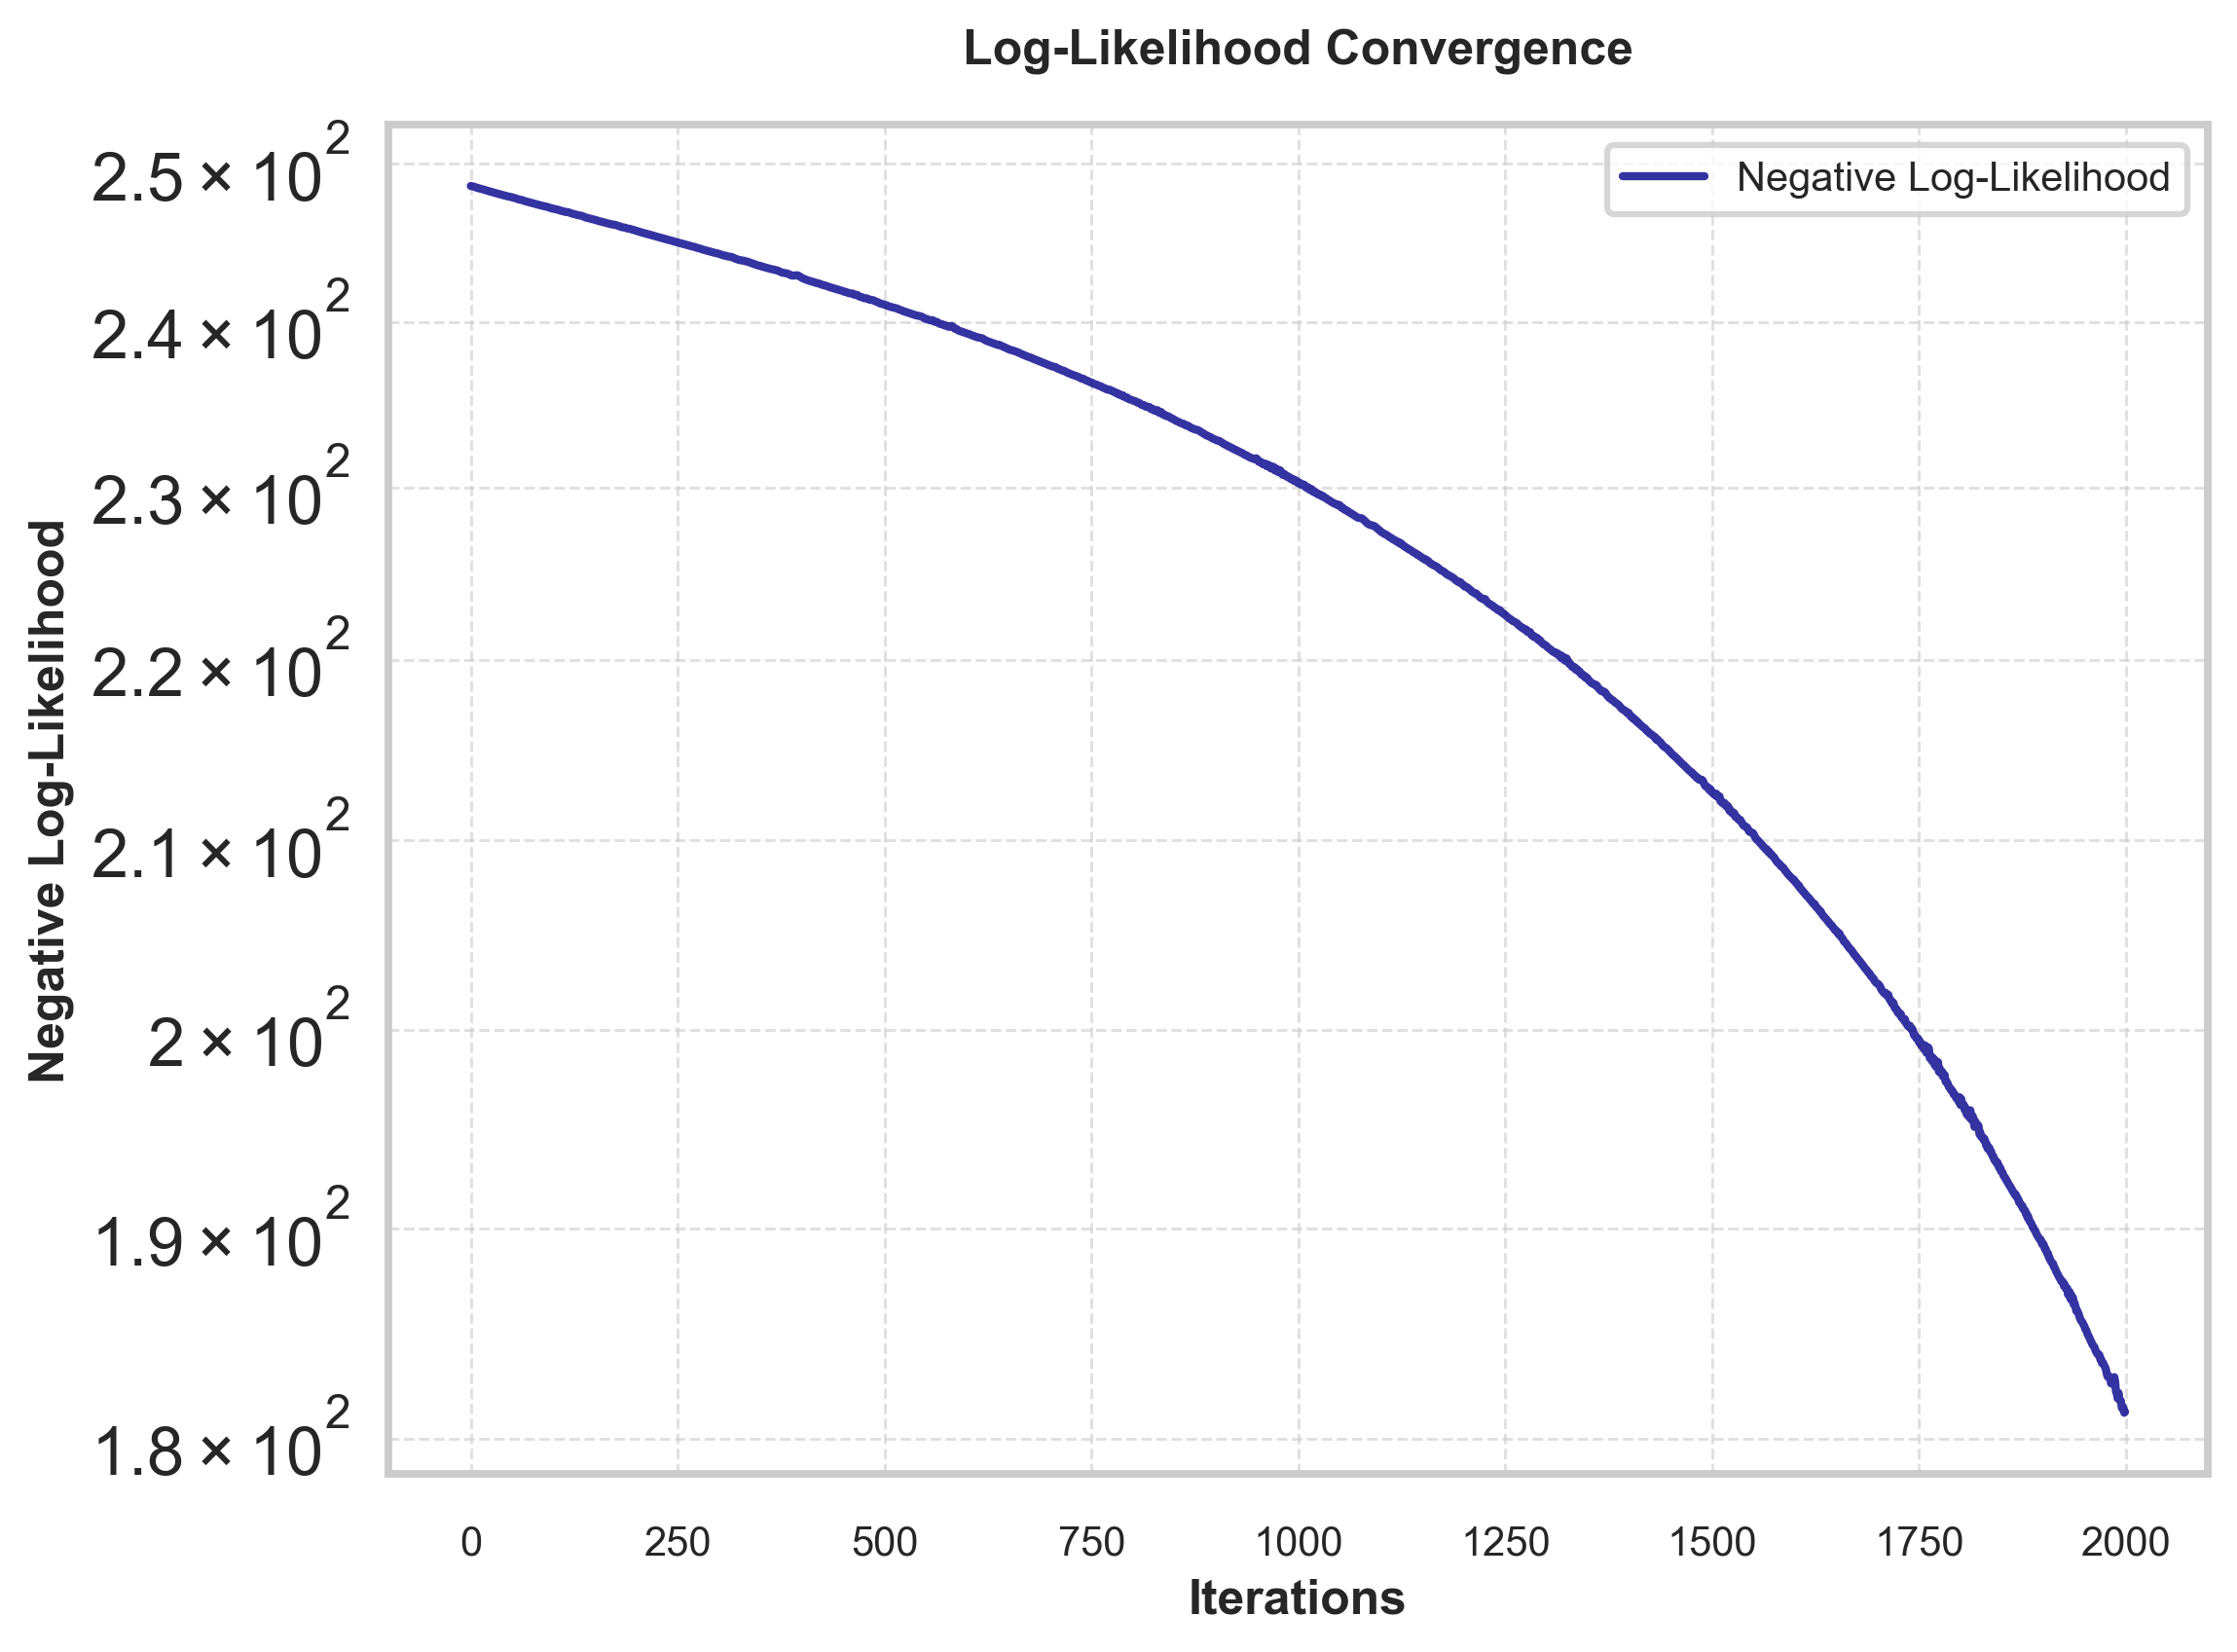

2025-03-11 18:30:11,149 - INFO - Removed 0/1 MLE estimates due to unphysical values (N or r < 0).


In [8]:
# Initial run to show training through gradient descent
mle_results_1 = Antikythera_Isotropic_Basic_Filter.max_likelihood_est(sampling_type = 'Adam', num_samples=1, num_iterations=2500, learning_rate=0.05, batch_size=50, key=32, derivative='analytic', plot_history=True, summary_table = None, save_path = None)

In [9]:
# Full optimisation using 100 initialisations from prior
if rerun_comp_expensive_analysis:
    mle_results_full = Antikythera_Isotropic_Basic_Filter.max_likelihood_est(sampling_type = 'Adam', num_samples=100, num_iterations=1000, learning_rate=0.1, batch_size=50, key=1, derivative='analytic', plot_history=False, summary_table = 5, save_path = 'stored_results/Anistropic_Basic_MLE_Results.pkl')
# if not run, load back data
else:
    mle_results_full = pd.read_pickle('stored_results/Anistropic_Basic_MLE_Results.pkl')

Optimizing MLE using Adam::   0%|          | 0/100 [00:00<?, ?it/s]

2025-03-11 18:41:21,529 - INFO - Removed 0/100 MLE estimates due to unphysical values (N or r < 0).


,N,r,x0,y0,alpha,sigma,Log-Likelihood
0,352.65638454123246,76.13215981189569,"[78.08,81.16,79.78,78.76,81.38,80.91]","[135.89,133.62,134.49,134.03,134.5 ,134.19]","[-2.53,-2.58,-2.55,-2.53,-2.56,-2.55]",0.47,-32.75862971804045
1,351.3939770100288,75.7924034195028,"[79.44,79.29,78.13,83.19,80.97,83.69]","[134.07,134.24,134.24,134.92,133.95,134.89]","[-2.56,-2.55,-2.53,-2.59,-2.55,-2.59]",0.69,-93.84184199045916
2,358.203252751503,77.77844488241189,"[77.66,77.5 ,80.13,84.17,77.5 ,75.62]","[138.54,137.46,136.12,137.25,134.9 ,133.55]","[-2.5 ,-2.52,-2.53,-2.59,-2.49,-2.48]",0.72,-124.62687724878974
3,355.34555717257564,76.00238083305872,"[76.6 ,71.26,77.9 ,83.41,75.11,78.67]","[137.11,138.26,134.36,135.24,132.46,133.85]","[-2.5 ,-2.43,-2.52,-2.58,-2.46,-2.51]",0.85,-131.91475578591167
4,364.28990560197104,78.20855551118818,"[78.7 ,66.41,79.63,84.71,79.6 ,69.94]","[138.15,142.19,136.63,137.78,136.08,130.85]","[-2.51,-2.34,-2.52,-2.58,-2.5 ,-2.36]",0.98,-147.91356577143281


2025-03-11 18:41:21,659 - INFO - MLE Run results saved to stored_results/Anistropic_Basic_MLE_Results.pkl


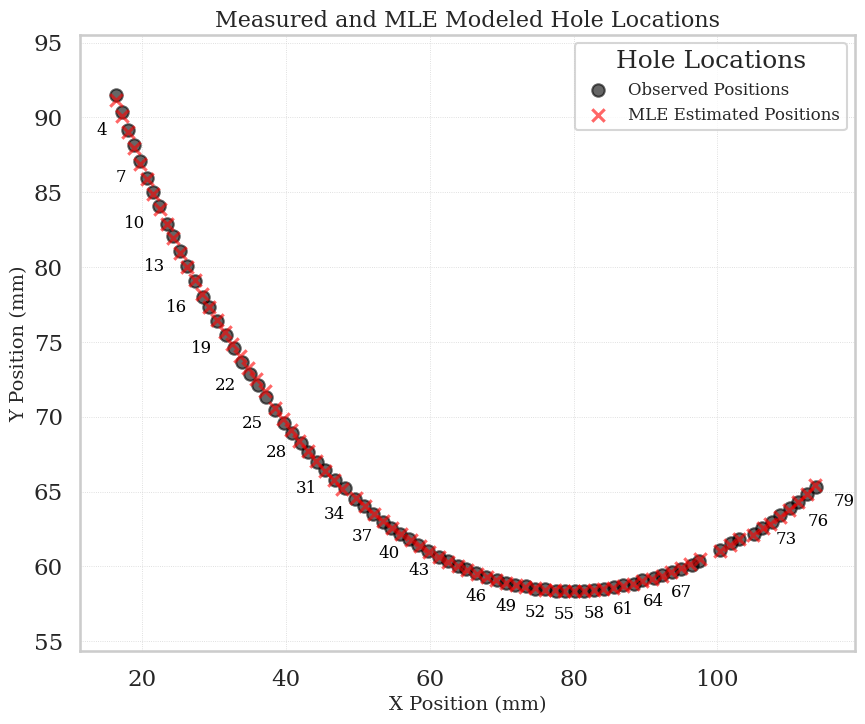

In [10]:
Antikythera_Isotropic_Basic_Filter.mle_analysis(mle_results_full)

## Posterior Analysis 

### Hamiltonian Monte Carlo (No U-Turn) Sampling 

#### **Burn-in Adaptation: NUTS vs. Ordinary HMC**

Unlike standard HMC, where step size and trajectory length must be manually tuned before sampling begins, NUTS uses the burn-in phase to learn and adjust these hyperparameters automatically.

| Feature                  | Ordinary HMC                          | NUTS (No-U-Turn Sampler) |
|--------------------------|--------------------------------------|--------------------------|
| **Step Size Adjustment** | Fixed, requires manual tuning       | Adapted dynamically via dual averaging |
| **Trajectory Length**    | Fixed number of leapfrog steps, must be pre-set | Automatically determined using U-turn detection |
| **Mass Matrix**          | Typically diagonal, no adaptation   | Adapted dynamically (dense or diagonal) based on posterior correlations |
| **Efficiency**           | Can be inefficient if hyperparameters are poorly chosen | Self-adjusting, more efficient for complex posteriors |

#### **No U Turn Criterion**
- In NUTS the sampler dynamically decides when to stop each trajectory, avoiding U-turns and prevents excessive computation
- Efficiently explores the posterior distribution.


### Burn In Analysis
- Determining optimal burn-in is not only important to ensure that samples have converged to stationary distribution but also allows sample to dynamically adjust to posterior (trajectory length, mass matrix)

#### Short Burn In - 50 Samples

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    354.71      4.02    354.53    347.85    361.00     62.26      1.09
  alpha[0]      3.74      0.00      3.74      3.73      3.74    139.86      1.04
  alpha[1]     -2.54      0.01     -2.54     -2.56     -2.53    224.17      1.03
  alpha[2]     -2.54      0.01     -2.54     -2.56     -2.53     64.04      1.09
  alpha[3]     -2.56      0.04     -2.56     -2.62     -2.49    100.26      1.03
  alpha[4]     -2.52      0.06     -2.52     -2.62     -2.43     74.95      1.01
  alpha[5]     -2.58      0.02     -2.58     -2.61     -2.54    150.62      1.03
         r     77.22      0.87     77.19     75.77     78.61     61.41      1.09
     sigma      0.10      0.01      0.09      0.09      0.10   2635.07      1.00
     x0[0]     79.61      0.62     79.58     78.57     80.59     63.55      1.08
     x0[1]     79.85      0.75     79.82     78.55     81.02    217.40      1.02
     x0[2]     79.86      0

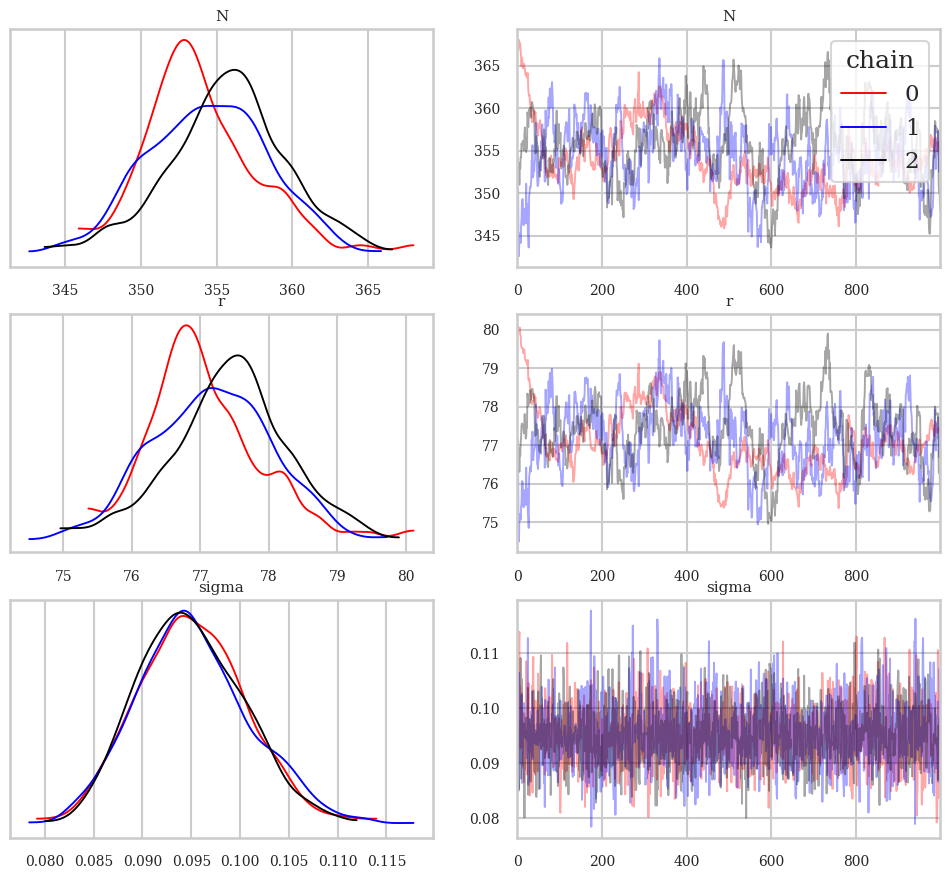

2025-03-11 18:42:04,085 - INFO - Total MCMC Run Time: 40.88 seconds 
 Non Burn-In Run Time: 35.55 seconds


In [11]:
short_burn_in = Antikythera_Isotropic_Basic_Filter.run_hmc_nuts(burnin_period=150, n_samples=1000, n_chains=3, step_size=1, acceptance_prob=0.8, dense_mass=False, summary = True, random_seed=0, save_path=None, traceplot= ['N', 'r', 'sigma'], progress_bar=True)

#### Long Burn In - 500 Samples

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.03      3.82    354.96    348.67    361.30    561.51      1.00
  alpha[0]      3.74      0.00      3.74      3.73      3.75    898.22      1.00
  alpha[1]     -2.54      0.01     -2.54     -2.56     -2.53   1216.71      1.00
  alpha[2]     -2.54      0.01     -2.54     -2.56     -2.52    571.90      1.00
  alpha[3]     -2.55      0.04     -2.55     -2.62     -2.48   1243.39      1.00
  alpha[4]     -2.54      0.06     -2.54     -2.63     -2.45   1363.98      1.00
  alpha[5]     -2.58      0.02     -2.58     -2.61     -2.54    907.03      1.00
         r     77.29      0.82     77.27     75.90     78.60    562.88      1.00
     sigma      0.09      0.01      0.09      0.09      0.10   2758.96      1.00
     x0[0]     79.65      0.59     79.63     78.67     80.60    596.67      1.00
     x0[1]     79.87      0.72     79.87     78.72     81.09   1326.08      1.00
     x0[2]     79.86      0

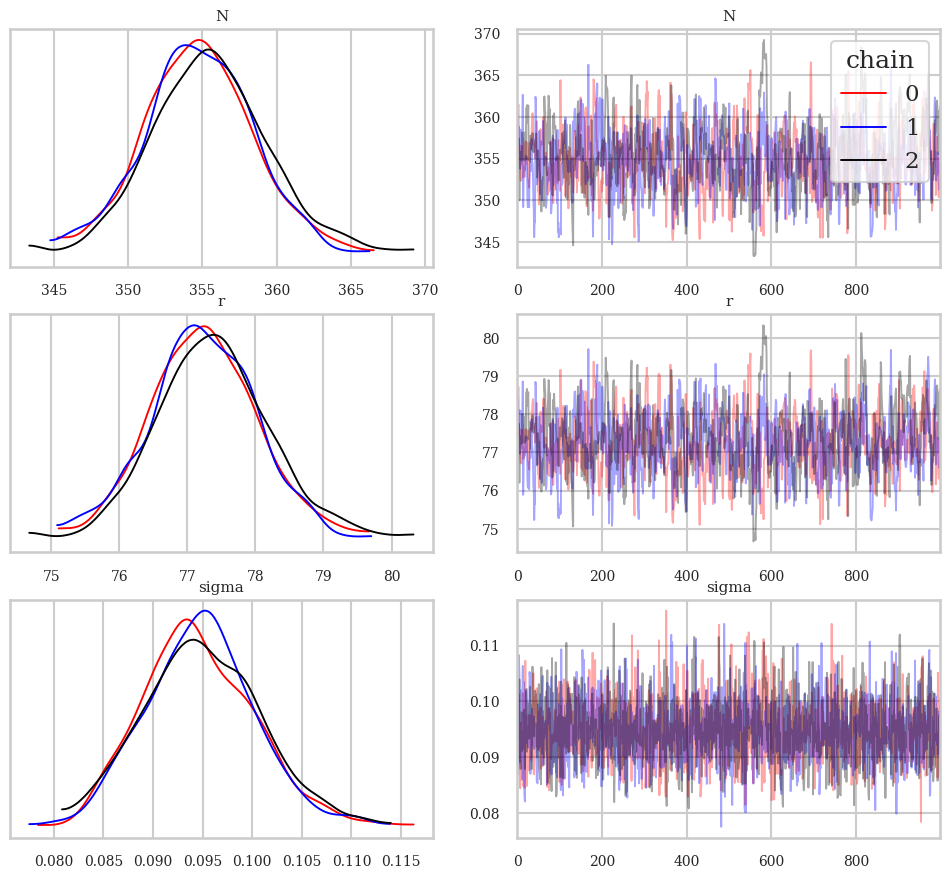

2025-03-11 18:42:45,439 - INFO - Total MCMC Run Time: 40.75 seconds 
 Non Burn-In Run Time: 25.47 seconds


In [12]:
long_burn_in = Antikythera_Isotropic_Basic_Filter.run_hmc_nuts(burnin_period=600, n_samples=1000, n_chains=3, step_size=1, acceptance_prob=0.8, dense_mass=False, summary = True, random_seed=0, save_path=None, traceplot= ['N', 'r', 'sigma'], progress_bar=True)

## **Optimising Initialisation**  

Although optimisation of initial parameters is less important than in traditional Hamiltonian Monte Carlo, as the **NUTS algorithm** dynamically adjusts hyperparameters during the **burn-in phase** and determines trajectory length automatically, it is still performed to **minimise the required burn-in period**. By selecting **good initialisation points**, the adaptation phase can be shortened, leading to **more efficient sampling**.  

### **Metrics Measured**  
- **Autocorrelation Length**: Estimated autocorrelation length.  
- **Number of Effective Samples**: Minimum effective sample size across parameters.  
- **GR Statistic**: Gelman-Rubin diagnostic (values close to 1 indicate convergence).  
- **Time per Iteration**: Average computation time per sample.  

### **Optimisation Criterion**  
- **Time Per Effective Sample**: Measures overall computational efficiency. Lower values indicate faster convergence and better sampling efficiency.  


In [17]:
if rerun_comp_expensive_analysis:
    step_size_range = [0.05, 0.1, 0.5, 1, 5]
    acceptance_prob_range = [0.65, 0.75, 0.85, 0.90]
    dense_mass_options = [False, True]
    
    nuts_optimal_params = Antikythera_Isotropic_Basic_Filter.run_hmc_optimisation(step_size_range, acceptance_prob_range, dense_mass_options, burnin_period=1000, n_samples=2000, n_chains=4, random_seed=0, save_path='stored_results/Istropic_Basic_HMC_Opt_Results.csv', no_table_results=5)



2025-03-11 19:03:37,699 - INFO - Running MCMC 1/40 | step_size=0.05, accept_prob=0.65, dense_mass=False
2025-03-11 19:04:08,032 - INFO - Total MCMC Run Time: 30.33 seconds 
 Non Burn-In Run Time: 20.22 seconds
2025-03-11 19:04:08,199 - INFO - Running MCMC 2/40 | step_size=0.05, accept_prob=0.65, dense_mass=True
2025-03-11 19:04:18,531 - INFO - Total MCMC Run Time: 10.33 seconds 
 Non Burn-In Run Time: 6.89 seconds
2025-03-11 19:04:18,687 - INFO - Running MCMC 3/40 | step_size=0.05, accept_prob=0.75, dense_mass=False
2025-03-11 19:04:49,472 - INFO - Total MCMC Run Time: 30.78 seconds 
 Non Burn-In Run Time: 20.52 seconds
2025-03-11 19:04:49,612 - INFO - Running MCMC 4/40 | step_size=0.05, accept_prob=0.75, dense_mass=True
2025-03-11 19:05:02,633 - INFO - Total MCMC Run Time: 13.02 seconds 
 Non Burn-In Run Time: 8.68 seconds
2025-03-11 19:05:02,773 - INFO - Running MCMC 5/40 | step_size=0.05, accept_prob=0.85, dense_mass=False
2025-03-11 19:05:37,557 - INFO - Total MCMC Run Time: 34.78 

## **Run Optimised NUTS**  

Once the **optimal hyperparameters** have been determined, they are used to generate posterior samples for analysis. This ensures that **sampling is as efficient as possible**, reducing the computational cost while maintaining statistical accuracy.  

Instead of running a fixed number of samples, this method **automatically determines** how many total samples need to be generated to achieve the desired number of **independent** (effectively uncorrelated) samples.  

### **Sampling Process**  
1. **Determine total samples needed per chain**  
   - Uses the estimated **autocorrelation length** to compute the necessary number of raw samples.  
   - Ensures that after thinning, the final dataset contains the required number of **independent** samples.  

2. **Run MCMC with optimised hyperparameters**  
   - Uses multiple **parallel chains** to improve convergence diagnostics.  
   - Computes the **Gelman-Rubin statistic (R-hat)** to verify sampling quality.  

3. **Thin the samples**  
   - Selects every `autocorrelation length` sample to ensure the remaining set is effectively independent.  

4. **Save and return results**  
    - **Returns two datasets**:  
    1. **Full posterior samples** (for visualization and diagnostics).  
    2. **Thinned posterior samples** (for statistical analysis, ensuring minimal correlation).  

In [21]:
nuts_optimal_params = pd.read_csv('stored_results/Istropic_Basic_HMC_Opt_Results.csv')
if rerun_comp_expensive_analysis:
    posterior_data, thinned_posterior = Antikythera_Isotropic_Basic_Filter.run_hmc_optimised(nuts_optimal_params, burnin_period=2000, n_samples=10000, n_chains =  4, random_seed=0, save_path = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', traceplot=None)

2025-03-11 19:19:36,146 - INFO - Running MCMC with Optimised Hyperparameters: step_size=1.0, accept_prob=0.75, dense_mass=True
Due to Autocorrelation Length: 1, the number of effective samples is reduced.
Total samples required to achieve 10000 effective samples: 10000
This is run on 4 parrallel chains each running 2500 samples.


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

2025-03-11 19:20:01,954 - INFO -  MCMC samples saved to stored_results/Isotropic_Basic_Opt_NUTS.nc
2025-03-11 19:20:01,954 - INFO - Total MCMC Run Time: 25.56 seconds 
 Non Burn-In Run Time: 14.20 seconds
2025-03-11 19:20:02,194 - INFO -  Over 4 chains, 10000 were run, 
Achieved Gelman-Rubin Statistic: 1.0021, 
Achieved Effective Samples: 5726, 
True Auto-correlation Length: 2
2025-03-11 19:20:02,197 - INFO - Total samples remaining after thinning: 5000
2025-03-11 19:20:03,349 - INFO - Full MCMC samples saved to stored_results/Isotropic_Basic_Opt_NUTS.nc
 Thinned MCMC samples saved to stored_results/Isotropic_Basic_Opt_NUTS_thinned.nc


## **Analyse NUTS Sampler**

2025-03-11 19:20:15,204 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.
2025-03-11 19:20:15,378 - INFO - NOTE: When comparing the results to the paper, the section indexes are not comparable, but there order is


,median,68%,90%,95%,99%
parameter,,,,,
N,354.883,+3.9060 − 3.9670,+6.3410 − 6.1460,+7.2300 − 7.2620,+8.4460 − 9.0140
alpha[0],3.740,+0.0030 − 0.0030,+0.0050 − 0.0050,+0.0060 − 0.0060,+0.0080 − 0.0080
alpha[1],-2.543,+0.0100 − 0.0100,+0.0170 − 0.0170,+0.0200 − 0.0200,+0.0270 − 0.0260
alpha[2],-2.541,+0.0100 − 0.0100,+0.0160 − 0.0160,+0.0180 − 0.0180,+0.0200 − 0.0230
alpha[3],-2.555,+0.0430 − 0.0410,+0.0710 − 0.0680,+0.0850 − 0.0800,+0.1140 − 0.1010
alpha[4],-2.541,+0.0580 − 0.0550,+0.0940 − 0.0930,+0.1070 − 0.1120,+0.1400 − 0.1410
alpha[5],-2.579,+0.0230 − 0.0220,+0.0370 − 0.0360,+0.0440 − 0.0430,+0.0620 − 0.0570
r,77.268,+0.8350 − 0.8580,+1.3630 − 1.3300,+1.5520 − 1.5770,+1.7790 − 1.9910
sigma,0.095,+0.0060 − 0.0060,+0.0100 − 0.0090,+0.0120 − 0.0110,+0.0160 − 0.0130


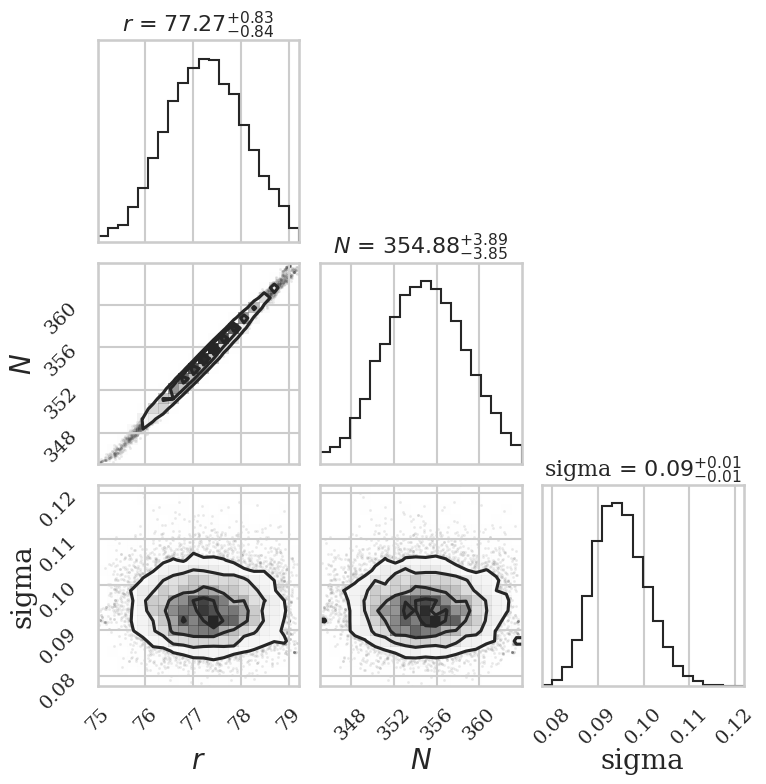

In [22]:
Antikythera_Isotropic_Basic_Filter.thinned_hcm_analysis(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', summary_table=True, corner_plot=["r", "N", "sigma"])

2025-03-11 19:20:28,966 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.


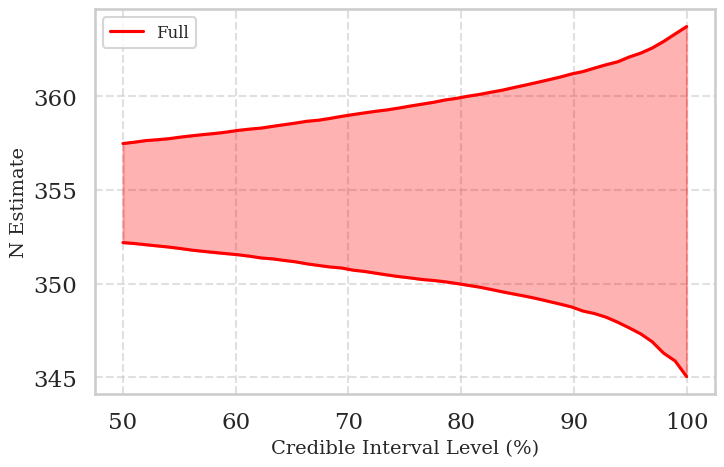

In [23]:
Antikythera_Isotropic_Basic_Filter.plot_credible_intervals(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', param="N", percentiles_range=(50, 100))

2025-03-11 19:20:31,462 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.


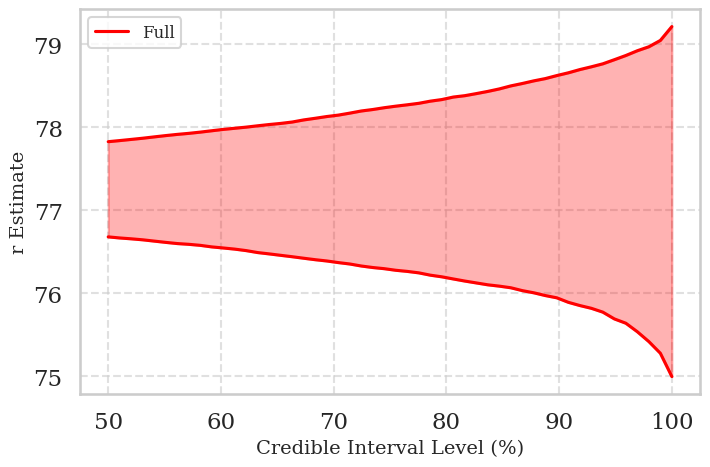

In [24]:
Antikythera_Isotropic_Basic_Filter.plot_credible_intervals(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', param="r", percentiles_range=(50, 100))

2025-03-11 19:20:34,399 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.


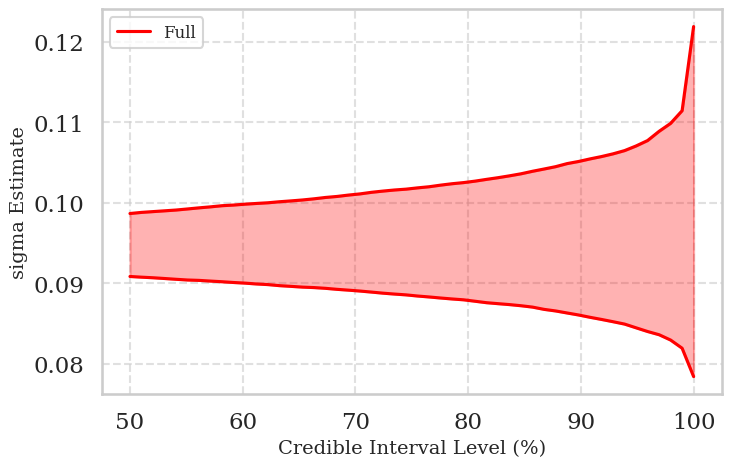

In [25]:
Antikythera_Isotropic_Basic_Filter.plot_credible_intervals(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', param="sigma", percentiles_range=(50, 100))

2025-03-11 19:20:37,840 - INFO - Loaded thinned posterior data from NetCDF file.
2025-03-11 19:20:37,840 - INFO - Loaded posterior data from NetCDF file.


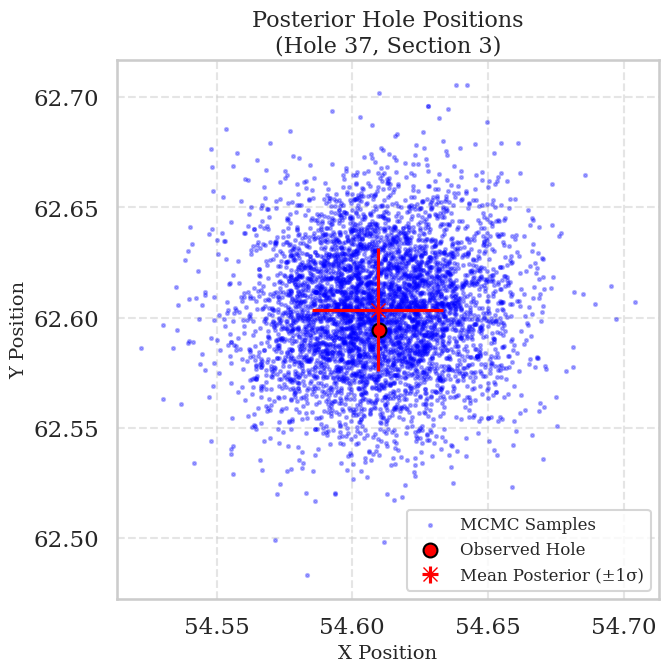

In [26]:
Hole_loc = Antikythera_Isotropic_Basic_Filter.plot_posterior_holes(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', hole_no=37, section_no=3)

2025-03-11 19:20:52,278 - INFO - Loaded thinned posterior data from NetCDF file.
2025-03-11 19:20:52,279 - INFO - Loaded posterior data from NetCDF file.


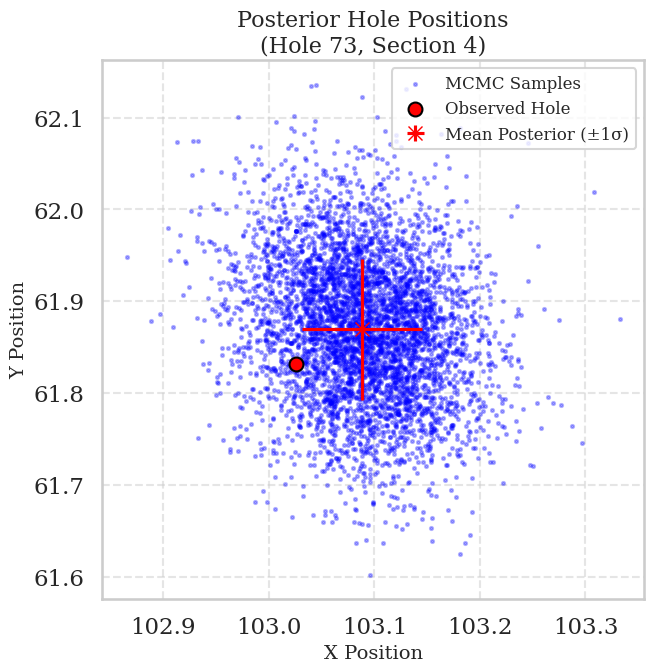

In [27]:
Hole_loc = Antikythera_Isotropic_Basic_Filter.plot_posterior_holes(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', hole_no=73, section_no=4 )